# Model Definition and Evaluation

## Table of Contents

1. [Model Selection](#model-selection)  
2. [Feature Engineering](#feature-engineering)  
3. [Hyperparameter Tuning](#hyperparameter-tuning)  
4. [Implementation](#implementation)  
5. [Evaluation Metrics](#evaluation-metrics)  
6. [Comparative Analysis](#comparative-analysis)  

Check CUDA

In [ ]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("CUDA devices:", torch.cuda.device_count())
print("Current device:", torch.cuda.current_device())

Check pixel coord file

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os

# Path to your folder containing images
image_folder = './objdet_input_data/objdet_input_images'

# Load the CSV file
csv_file = './objdet_input_data/merged_pixel_coordinates.csv'
df = pd.read_csv(csv_file)

# Select 20 random rows from the DataFrame
random_rows = df.sample(n=20, random_state=42)  # 'random_state' ensures reproducibility

# Loop through the randomly selected rows
for _, row in random_rows.iterrows():
    # Get image file name and bounding box coordinates
    image_name = row['image_name']
    x_min, y_min, x_max, y_max = int(row['x_min']), int(row['y_min']), int(row['x_max']), int(row['y_max'])
    
    # Load the image
    image_path = os.path.join(image_folder, image_name)
    image = cv2.imread(image_path)
    
    # Check if the image is loaded successfully
    if image is None:
        print(f"Error: Could not load image {image_name}")
        continue
    
    # Convert image from BGR (OpenCV format) to RGB (matplotlib format)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Draw the bounding box on the image
    cv2.rectangle(image_rgb, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)  # Red bounding box
    
    # Display the image with the bounding box
    plt.figure(figsize=(10, 10))
    plt.imshow(image_rgb)
    plt.axis('off')  # Turn off axis
    plt.title(image_name)
    plt.show()


Definitions and constraints

In [ ]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Paths to data
image_dir = "./objdet_input_data/objdet_input_images"
csv_path = "./objdet_input_data/merged_pixel_coordinates.csv"

# Constants
IMAGE_SIZE = (256, 256)  # Resize images to 128x128
BATCH_SIZE = 16
EPOCHS = 100

### Model Selection

In this project, we considered various models for object detection, including traditional machine learning algorithms like Support Vector Machines (SVMs) and Random Forests, as well as more modern deep learning models. After careful consideration, we chose a Convolutional Neural Network (CNN) architecture due to its superior ability to learn hierarchical features directly from image data. For bounding box prediction, we used a CNN-based regression model with two output branches: one for binary classification (object/no object) and one for bounding box regression. This approach is well-suited for tasks where both classification and localization are required.


### Feature Engineering

For this task, our primary feature engineering efforts revolved around preprocessing the images and the bounding box data. Specifically, we resized the images to a uniform size of 256x256 pixels to make them compatible with our model. Additionally, we normalized the pixel values to be in the range [0, 1] by dividing the pixel values by 255. 

In terms of bounding box preprocessing, we scaled the coordinates according to the resizing ratio of the image and normalized the bounding box values to lie between 0 and 1. This ensured that the model would work with relative, scale-invariant coordinates rather than pixel-based coordinates. We also created a binary class label indicating whether an object was present in the image or not, which helped us train the classification branch of the model.


In [ ]:
# Load bounding box data
bbox_data = pd.read_csv(csv_path)

# Function to load images
def load_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)  # Load in color (BGR format)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB format
    image = image / 255.0  # Normalize pixel values to [0, 1]
    return image

# Function to preprocess bounding boxes
def preprocess_bboxes(row, original_size, resized_size):
    x_min, y_min, x_max, y_max = row[['x_min', 'y_min', 'x_max', 'y_max']]
    orig_height, orig_width = original_size
    resized_height, resized_width = resized_size

    if x_min == -1 and y_min == -1 and x_max == -1 and y_max == -1:
        return [-1, -1, -1, -1]  # No object case

    # Scale the bounding box coordinates according to the resizing ratio
    x_min = x_min * (resized_width / orig_width)
    y_min = y_min * (resized_height / orig_height)
    x_max = x_max * (resized_width / orig_width)
    y_max = y_max * (resized_height / orig_height)

    # Normalize coordinates to [0, 1]
    x_min /= resized_width
    y_min /= resized_height
    x_max /= resized_width
    y_max /= resized_height

    return [x_min, y_min, x_max, y_max]

# Prepare dataset
images = []
bboxes = []
has_objects = []
for _, row in bbox_data.iterrows():
    img_path = os.path.join(image_dir, row['image_name'])
    if os.path.exists(img_path):
        # Load image without resizing to get original dimensions
        original_image = load_image(img_path)
        original_size = (original_image.shape[0], original_image.shape[1])

        # Preprocess bounding box
        bbox = preprocess_bboxes(row, original_size, IMAGE_SIZE)
        bboxes.append(bbox)

        # Add object presence label
        has_objects.append(0 if bbox == [-1, -1, -1, -1] else 1)

        # Resize the image
        resized_image = cv2.resize(original_image, IMAGE_SIZE)
        images.append(resized_image)

images = np.array(images)
bboxes = np.array(bboxes)
has_objects = np.array(has_objects)

# Split data
X_train, X_val, y_train_bboxes, y_val_bboxes, y_train_class, y_val_class = train_test_split(
    images, bboxes, has_objects, test_size=0.2, random_state=42
)

## Hyperparameter Tuning

We did intensive exploration into hyperparameter tuning, among other approaches we used a keras tuner, but the results of these approaches did not bring any better results unfortunately. So we did not include them here but an exemplary tuner approach can be seen in the file exemplary_tuner_approach_objdet_standalone_model_1_2.ipynb.

### Implementation

We implemented a custom CNN model with two output branches using TensorFlow and Keras. The first branch was designed for binary classification (whether an object is present in the image or not), and the second branch was dedicated to bounding box regression. 

The architecture included multiple convolutional layers followed by max-pooling operations to reduce spatial dimensions, as well as fully connected layers for final classification and regression. We chose the Adam optimizer for training the model. The loss function was a combination of binary cross-entropy for classification and Huber loss for bounding box regression. We used dropout layers to prevent overfitting, given the high complexity of the model.


In [ ]:
# Define Huber loss
def huber_loss(y_true, y_pred, delta=1.0):
    error = y_true - y_pred
    is_small_error = tf.abs(error) <= delta
    small_error_loss = 0.5 * tf.square(error)
    large_error_loss = delta * (tf.abs(error) - 0.5 * delta)
    return tf.where(is_small_error, small_error_loss, large_error_loss)

# Custom combined loss function
def custom_loss(y_true, y_pred):
    class_true, bbox_true = y_true
    class_pred, bbox_pred = y_pred
    
    # Binary cross-entropy for classification
    class_loss = tf.keras.losses.binary_crossentropy(class_true, class_pred)
    
    # Huber loss for bounding box regression (only for positive class)
    bbox_loss = huber_loss(bbox_true, bbox_pred)
    bbox_loss = tf.where(class_true == 1, bbox_loss, 0.0)
    
    return class_loss + bbox_loss

# Define the model architecture
def create_model_with_no_object_detection():
    inputs = layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    
    # Shared convolutional base
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    # Additional layers for optimization
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Flatten()(x)
    
    # Fully connected layers
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    
    # Classification branch
    class_output = layers.Dense(1, activation='sigmoid', name='class_output')(x)
    
    # Bounding box regression branch
    bbox_output = layers.Dense(4, activation='linear', name='bbox_output')(x)
    
    model = models.Model(inputs, [class_output, bbox_output])
    return model

# Compile the model
model = create_model_with_no_object_detection()
model.compile(
    optimizer='adam',
    loss={
        'class_output': 'binary_crossentropy',
        'bbox_output': huber_loss
    },
    loss_weights={
        'class_output': 1.0,
        'bbox_output': 1.0
    },
    metrics={
        'class_output': ['accuracy'],
        'bbox_output': ['mae']
    }
)

# Train the model
history = model.fit(
    X_train, {'class_output': y_train_class, 'bbox_output': y_train_bboxes},
    validation_data=(X_val, {'class_output': y_val_class, 'bbox_output': y_val_bboxes}),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# Save the trained model
model_save_path = "objdet_with_no_object_model.h5"
model.save(model_save_path)
print(f"Model saved to {model_save_path}")


### Evaluation Metrics

For evaluating the performance of the model, we used several metrics:

1. **Accuracy**: This was used to evaluate the performance of the classification branch, i.e., whether the model correctly identified the presence or absence of an object.
  
2. **Mean Absolute Error (MAE)**: This was used for bounding box regression to measure the average difference between the true and predicted bounding box coordinates.

3. **Intersection over Union (IoU)**: We calculated the IoU between the predicted and ground truth bounding boxes to assess the quality of our object localization.

4. **Confusion Matrix and ROC Curve**: We plotted confusion matrices and calculated the ROC curve to further analyze the performance of the classification branch.


Epoch 1/100
149/149 [==============================] - 33s 110ms/step - loss: 0.6375 - class_output_loss: 0.4660 - bbox_output_loss: 0.1715 - class_output_accuracy: 0.8338 - bbox_output_mae: 0.4382 - val_loss: 0.5991 - val_class_output_loss: 0.4450 - val_bbox_output_loss: 0.1540 - val_class_output_accuracy: 0.8389 - val_bbox_output_mae: 0.3401
Epoch 2/100
149/149 [==============================] - 12s 78ms/step - loss: 0.6104 - class_output_loss: 0.4504 - bbox_output_loss: 0.1600 - class_output_accuracy: 0.8371 - bbox_output_mae: 0.4109 - val_loss: 0.6272 - val_class_output_loss: 0.4681 - val_bbox_output_loss: 0.1591 - val_class_output_accuracy: 0.8389 - val_bbox_output_mae: 0.3269
Epoch 3/100
149/149 [==============================] - 9s 58ms/step - loss: 0.6071 - class_output_loss: 0.4486 - bbox_output_loss: 0.1585 - class_output_accuracy: 0.8371 - bbox_output_mae: 0.4054 - val_loss: 0.6127 - val_class_output_loss: 0.4576 - val_bbox_output_loss: 0.1551 - val_class_output_accuracy: 0.

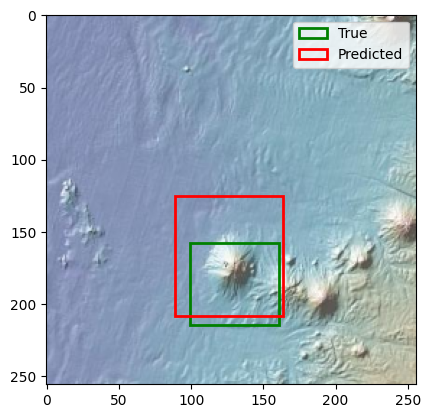

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


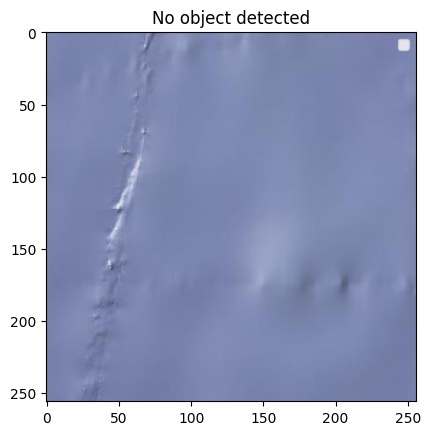

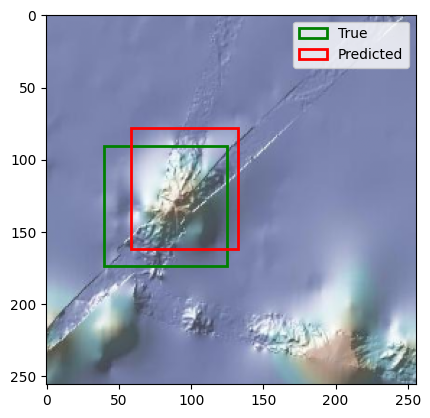

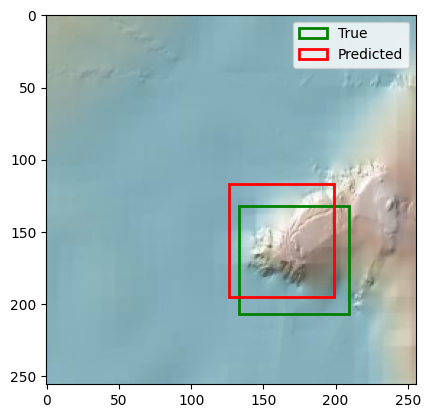

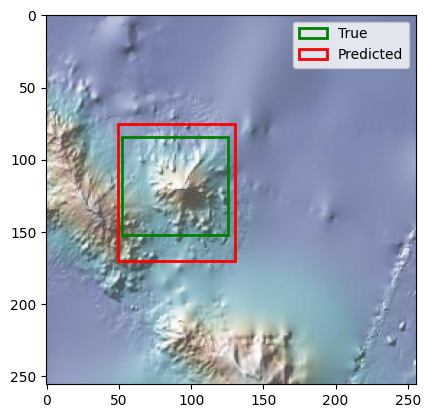

In [2]:
# Evaluate the model
val_loss = model.evaluate(
    X_val, {'class_output': y_val_class, 'bbox_output': y_val_bboxes}
)
print(f"Validation Loss: {val_loss}")

# Visualization of predictions
def plot_predictions_with_no_object(images, true_bboxes, pred_bboxes, true_classes, pred_classes):
    for i in range(5):  # Show 5 examples
        img = images[i]
        true_bbox = true_bboxes[i]
        pred_bbox = pred_bboxes[i]
        true_class = true_classes[i]
        pred_class = pred_classes[i]

        plt.imshow(img)
        if pred_class < 0.5:  # No object detected
            plt.title("No object detected")
        else:
            h, w, _ = img.shape
            true_rect = [
                true_bbox[0] * w, true_bbox[1] * h,
                (true_bbox[2] - true_bbox[0]) * w, (true_bbox[3] - true_bbox[1]) * h
            ]
            plt.gca().add_patch(plt.Rectangle(
                (true_rect[0], true_rect[1]),
                true_rect[2], true_rect[3],
                edgecolor='green', facecolor='none', lw=2, label='True'
            ))
            pred_rect = [
                pred_bbox[0] * w, pred_bbox[1] * h,
                (pred_bbox[2] - pred_bbox[0]) * w, (pred_bbox[3] - pred_bbox[1]) * h
            ]
            plt.gca().add_patch(plt.Rectangle(
                (pred_rect[0], pred_rect[1]),
                pred_rect[2], pred_rect[3],
                edgecolor='red', facecolor='none', lw=2, label='Predicted'
            ))
        plt.legend()
        plt.show()

# Make predictions
pred_classes, pred_bboxes = model.predict(X_val)
plot_predictions_with_no_object(X_val, y_val_bboxes, pred_bboxes, y_val_class, pred_classes)


## More Evaluation Data

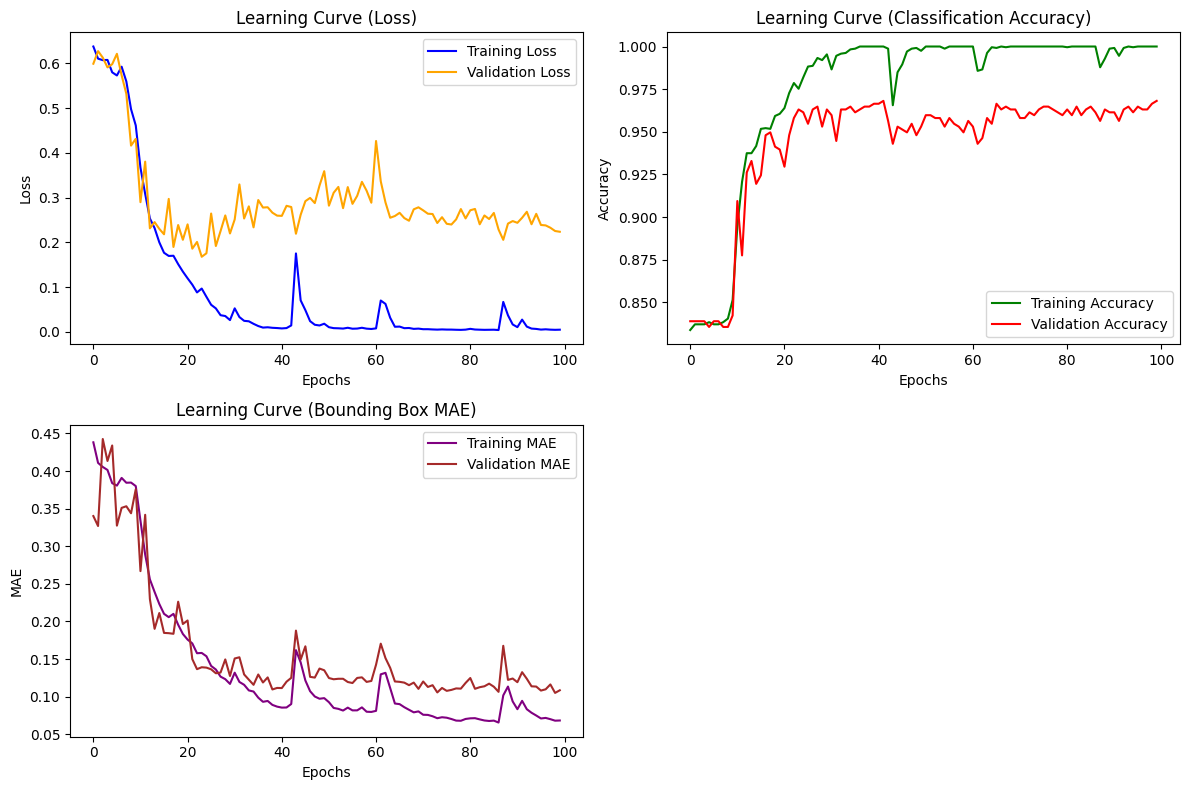

Average IoU on Validation Set (excluding true no-object cases): 0.5122


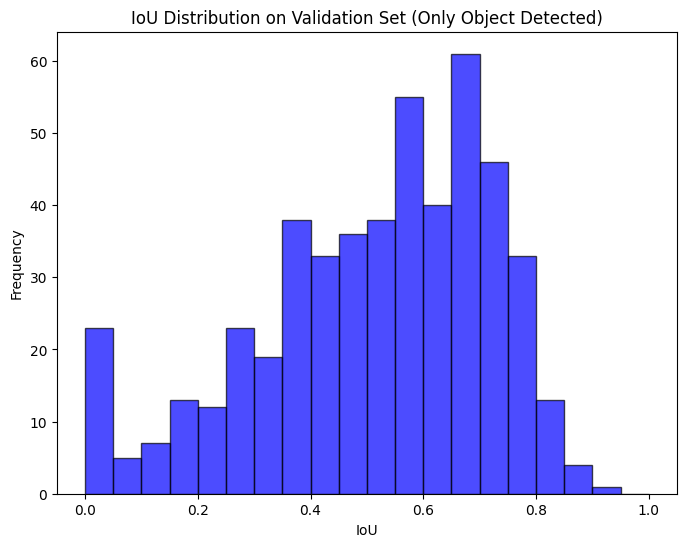

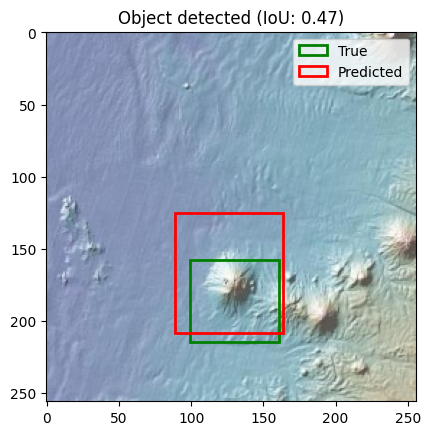

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


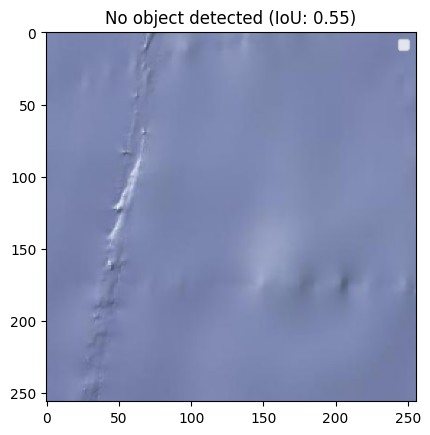

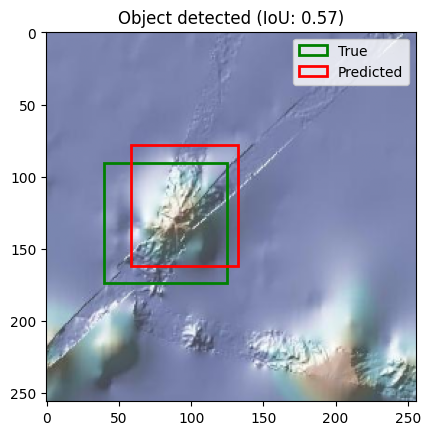

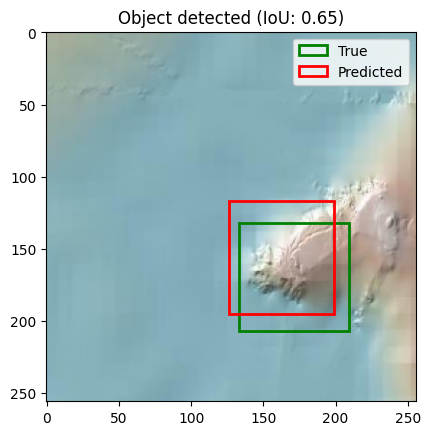

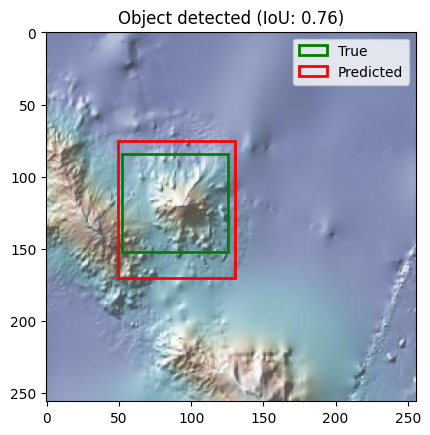

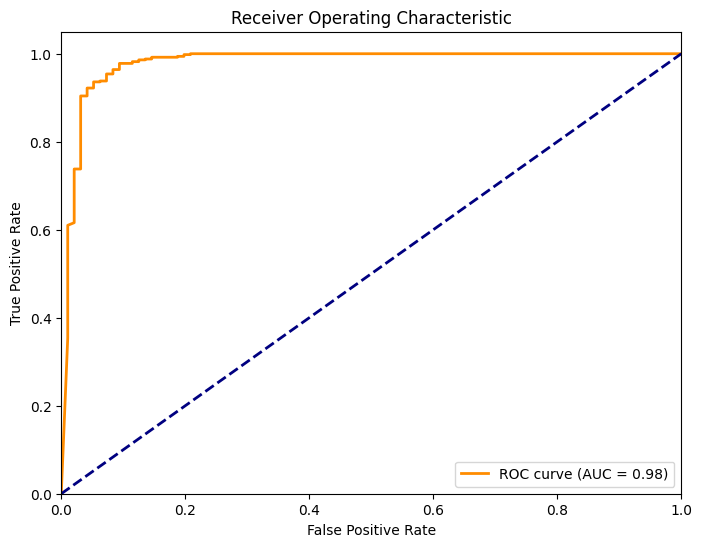

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.86      0.90        96
           1       0.97      0.99      0.98       500

    accuracy                           0.97       596
   macro avg       0.95      0.93      0.94       596
weighted avg       0.97      0.97      0.97       596



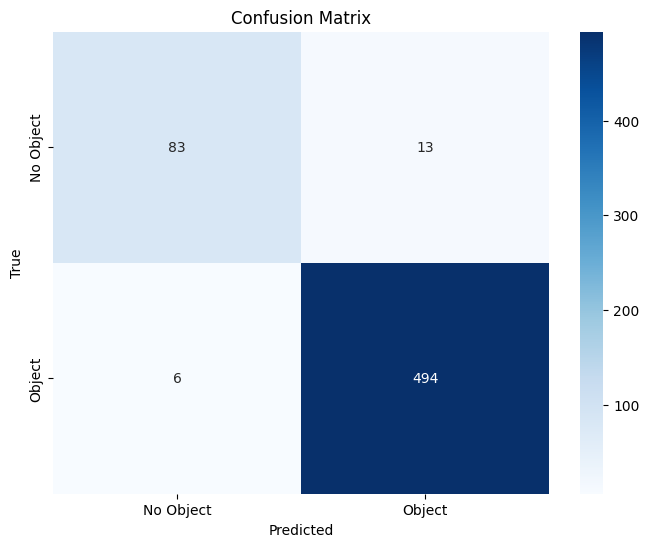

Displaying 19 misclassified images...


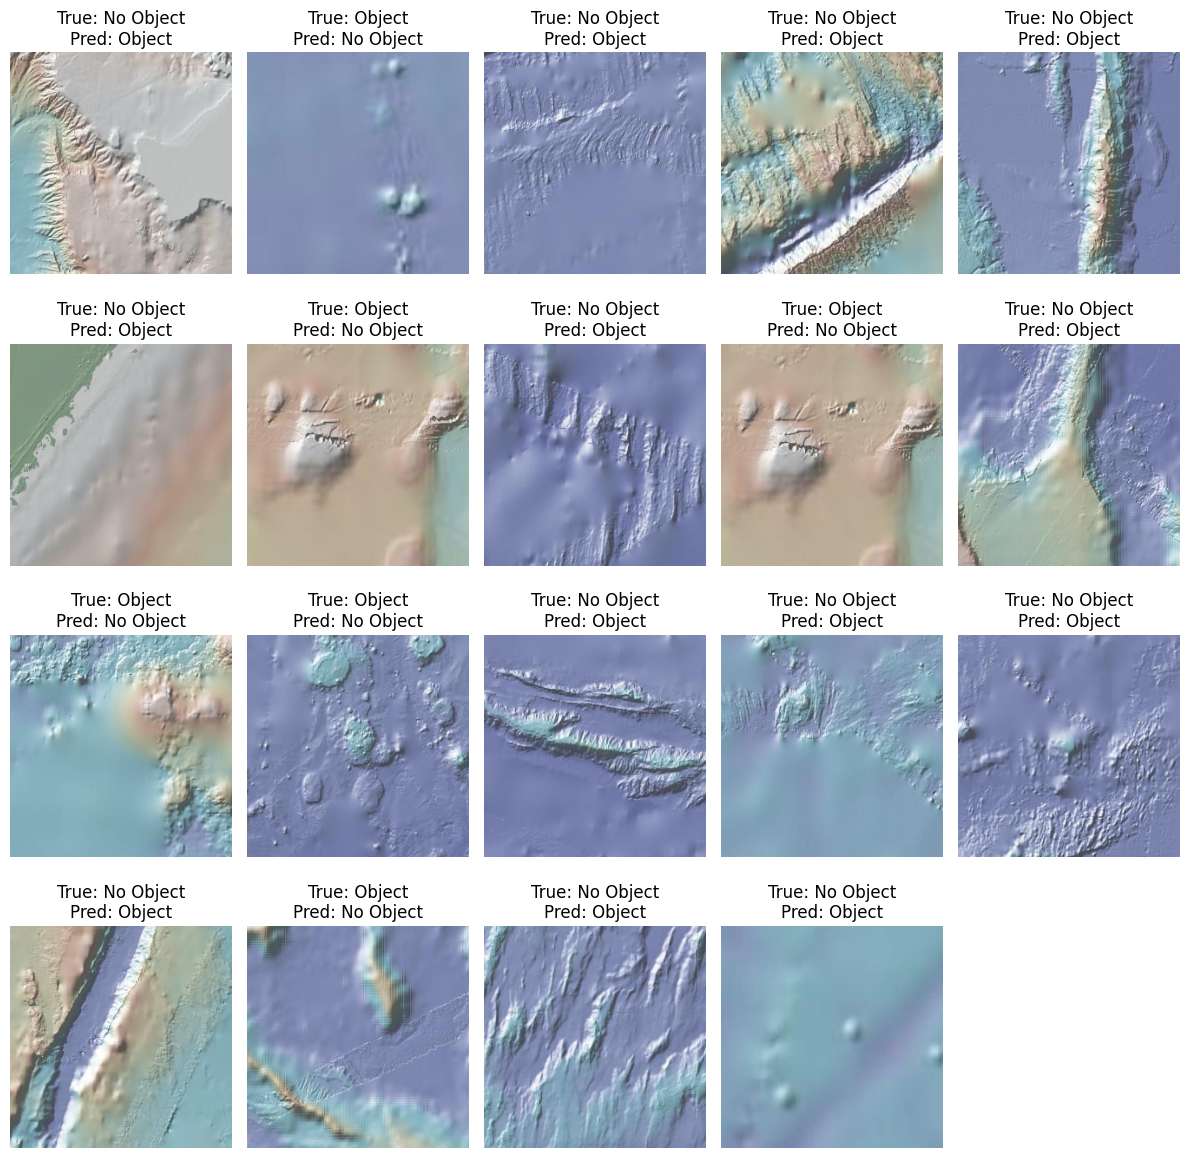

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns

# Plot the learning curve (Training & Validation Loss, Accuracy, and MAE)
def plot_learning_curves(history):
    # Extract the loss values from history
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Extract the accuracy and MAE values from history (for classification and bbox prediction)
    class_accuracy = history.history['class_output_accuracy']
    val_class_accuracy = history.history['val_class_output_accuracy']
    
    bbox_mae = history.history['bbox_output_mae']
    val_bbox_mae = history.history['val_bbox_output_mae']
    
    # Plot the loss curve
    plt.figure(figsize=(12, 8))

    # Plot Loss Curve
    plt.subplot(2, 2, 1)
    plt.plot(loss, label='Training Loss', color='blue')
    plt.plot(val_loss, label='Validation Loss', color='orange')
    plt.title("Learning Curve (Loss)")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Plot Accuracy Curve for Classification
    plt.subplot(2, 2, 2)
    plt.plot(class_accuracy, label='Training Accuracy', color='green')
    plt.plot(val_class_accuracy, label='Validation Accuracy', color='red')
    plt.title("Learning Curve (Classification Accuracy)")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    # Plot MAE Curve for Bounding Box Regression
    plt.subplot(2, 2, 3)
    plt.plot(bbox_mae, label='Training MAE', color='purple')
    plt.plot(val_bbox_mae, label='Validation MAE', color='brown')
    plt.title("Learning Curve (Bounding Box MAE)")
    plt.xlabel("Epochs")
    plt.ylabel("MAE")
    plt.legend()

    # Show all plots
    plt.tight_layout()
    plt.show()

# Function to calculate IoU (Intersection over Union) excluding true no-object cases
def calculate_iou(true_bbox, pred_bbox, true_class, pred_class):
    # Exclude IoU calculation if the true class has no object (true_class < 0.5)
    if true_class < 0.5:  # True class has no object, so exclude IoU calculation
        return None  # Skip IoU calculation for true no-object cases

    x_min_true, y_min_true, x_max_true, y_max_true = true_bbox
    x_min_pred, y_min_pred, x_max_pred, y_max_pred = pred_bbox

    # Calculate intersection
    inter_x_min = max(x_min_true, x_min_pred)
    inter_y_min = max(y_min_true, y_min_pred)
    inter_x_max = min(x_max_true, x_max_pred)
    inter_y_max = min(y_max_true, y_max_pred)

    inter_width = max(0, inter_x_max - inter_x_min)
    inter_height = max(0, inter_y_max - inter_y_min)
    intersection = inter_width * inter_height

    # Calculate union
    true_area = (x_max_true - x_min_true) * (y_max_true - y_min_true)
    pred_area = (x_max_pred - x_min_pred) * (y_max_pred - y_min_pred)
    union = true_area + pred_area - intersection

    return intersection / union if union > 0 else 0.0

# Function to evaluate IoU for validation set (excluding true no-object cases)
def evaluate_iou(y_val_bboxes, pred_bboxes, y_val_class, pred_classes):
    ious = []
    for i in range(len(y_val_bboxes)):
        iou = calculate_iou(y_val_bboxes[i], pred_bboxes[i], y_val_class[i], pred_classes[i])
        if iou is not None:  # Only append IoU values for valid cases
            ious.append(iou)

    average_iou = np.mean(ious)
    print(f"Average IoU on Validation Set (excluding true no-object cases): {average_iou:.4f}")

    return ious

# Function to plot IoU distribution (excluding true no-object cases)
def plot_iou_distribution(ious):
    plt.figure(figsize=(8, 6))
    plt.hist(ious, bins=20, range=(0, 1), color='blue', alpha=0.7, edgecolor='black')
    plt.title("IoU Distribution on Validation Set (Only Object Detected)")
    plt.xlabel("IoU")
    plt.ylabel("Frequency")
    plt.show()

# Function to plot predictions with IoU
def plot_predictions_with_iou(images, true_bboxes, pred_bboxes, true_classes, pred_classes, ious, num_examples=5):
    for i in range(num_examples):
        img = images[i]
        true_bbox = true_bboxes[i]
        pred_bbox = pred_bboxes[i]
        true_class = true_classes[i]
        pred_class = pred_classes[i]
        iou = ious[i]

        plt.imshow(img)
        if pred_class < 0.5:  # No object detected by model
            plt.title(f"No object detected (IoU: {iou:.2f})")
        else:
            h, w, _ = img.shape
            true_rect = [
                true_bbox[0] * w, true_bbox[1] * h,
                (true_bbox[2] - true_bbox[0]) * w, (true_bbox[3] - true_bbox[1]) * h
            ]
            plt.gca().add_patch(plt.Rectangle(
                (true_rect[0], true_rect[1]),
                true_rect[2], true_rect[3],
                edgecolor='green', facecolor='none', lw=2, label='True'
            ))
            pred_rect = [
                pred_bbox[0] * w, pred_bbox[1] * h,
                (pred_bbox[2] - pred_bbox[0]) * w, (pred_bbox[3] - pred_bbox[1]) * h
            ]
            plt.gca().add_patch(plt.Rectangle(
                (pred_rect[0], pred_rect[1]),
                pred_rect[2], pred_rect[3],
                edgecolor='red', facecolor='none', lw=2, label='Predicted'
            ))
            plt.title(f"Object detected (IoU: {iou:.2f})")
        plt.legend()
        plt.show()

# Function to plot ROC Curve
def plot_roc_curve(true_classes, pred_classes):
    # Get the ROC curve data (use the raw predicted probabilities for the ROC curve)
    fpr, tpr, thresholds = roc_curve(true_classes, pred_classes)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Function to plot confusion matrix
def plot_confusion_matrix(true_classes, pred_classes):
    cm = confusion_matrix(true_classes, pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Object', 'Object'], yticklabels=['No Object', 'Object'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Function to print classification report (precision, recall, f1-score, support)
def print_classification_report(true_classes, pred_classes):
    report = classification_report(true_classes, pred_classes)
    print("Classification Report:")
    print(report)

def display_misclassified_images(X_val, y_val_class, pred_class_labels, num_examples=5):
    # Identify misclassified images
    misclassified_indices = [i for i in range(len(y_val_class)) if y_val_class[i] != pred_class_labels[i]]
    
    # If you want to display all misclassified images, just use the misclassified indices
    misclassified_images = [X_val[i] for i in misclassified_indices]
    misclassified_labels = [y_val_class[i] for i in misclassified_indices]
    misclassified_preds = [pred_class_labels[i] for i in misclassified_indices]
    
    # Display the misclassified images
    num_misclassified = len(misclassified_images)
    print(f"Displaying {num_misclassified} misclassified images...")

    plt.figure(figsize=(12, 12))
    
    for i in range(num_misclassified):
        ax = plt.subplot((num_misclassified // 5) + 1, 5, i + 1)  # Grid layout for images
        plt.imshow(misclassified_images[i])
        true_label = "Object" if misclassified_labels[i] == 1 else "No Object"
        pred_label = "Object" if misclassified_preds[i] == 1 else "No Object"
        ax.set_title(f"True: {true_label}\nPred: {pred_label}")
        ax.axis("off")
    
    plt.tight_layout()
    plt.show()

# Assuming you have your model's history and prediction results
# Example usage:

plot_learning_curves(history)  # Plot training/validation learning curves

# Assuming you have the following data available:
# y_val_bboxes: Ground truth bounding boxes for validation set
# pred_bboxes: Predicted bounding boxes by the model
# y_val_class: Ground truth class labels for validation set
# pred_classes: Predicted class probabilities by the model
# X_val: Validation images

# Calculate and evaluate IoU
ious = evaluate_iou(y_val_bboxes, pred_bboxes, y_val_class, pred_classes)  # Calculate IoU values

# Plot the IoU distribution (excluding true no-object cases)
plot_iou_distribution(ious)  # Plot the distribution of IoU values

# Visualize predictions with IoU
plot_predictions_with_iou(X_val, y_val_bboxes, pred_bboxes, y_val_class, pred_classes, ious)  # Visualize predictions with IoU

# Assuming you have true_classes (ground truth labels) and pred_classes (model predictions)

# Convert continuous probabilities to binary labels for classification metrics
pred_class_labels = (pred_classes >= 0.5).astype(int)  # Convert probabilities to 0 or 1

# Plot the ROC curve using raw probabilities
plot_roc_curve(y_val_class, pred_classes)  # true labels vs. predicted probabilities

# Print the classification report using binary labels
print_classification_report(y_val_class, pred_class_labels)  # true labels vs. predicted binary labels

# Plot the confusion matrix using binary labels
plot_confusion_matrix(y_val_class, pred_class_labels)  # true labels vs. predicted binary labels

# Assuming you have the following variables:
# X_val: Validation images
# y_val_class: True labels for validation
# pred_class_labels: Predicted binary labels

# Display all misclassified images
display_misclassified_images(X_val, y_val_class, pred_class_labels)


## Test on unseen unlabeled data

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Path to the new data (unlabeled)
unlabeled_image_dir = "../1_DatasetCharacteristics/seamount_images_equal_tiles_cropped"

# Function to load images (same as in training)
def load_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)  # Load in color (BGR format)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB format
    image = image / 255.0  # Normalize pixel values to [0, 1]
    return image

# Function to plot predictions (same as before)
def plot_predictions_with_no_object(images, pred_bboxes, pred_classes):
    for i in range(20):  # Show 5 examples
        img = images[i]
        pred_bbox = pred_bboxes[i]
        pred_class = pred_classes[i]

        plt.imshow(img)
        if pred_class < 0.5:  # No object detected
            plt.title("No object detected")
        else:
            h, w, _ = img.shape
            pred_rect = [
                pred_bbox[0] * w, pred_bbox[1] * h,
                (pred_bbox[2] - pred_bbox[0]) * w, (pred_bbox[3] - pred_bbox[1]) * h
            ]
            plt.gca().add_patch(plt.Rectangle(
                (pred_rect[0], pred_rect[1]),
                pred_rect[2], pred_rect[3],
                edgecolor='red', facecolor='none', lw=2, label='Predicted'
            ))
        plt.legend()
        plt.show()

# Load the trained model (if not already loaded)
# If you already have the model loaded, you can skip this step.
# model = load_model('objdet_with_no_object_model.h5', custom_objects={'huber_loss': huber_loss})

# Load and preprocess unseen images
unlabeled_images = []
for image_name in os.listdir(unlabeled_image_dir):
    img_path = os.path.join(unlabeled_image_dir, image_name)
    if os.path.exists(img_path):
        img = load_image(img_path)
        resized_img = cv2.resize(img, IMAGE_SIZE)  # Resize images to match the model input size
        unlabeled_images.append(resized_img)

unlabeled_images = np.array(unlabeled_images)

# Make predictions on the unseen data
pred_classes, pred_bboxes = model.predict(unlabeled_images)

# Visualize the predictions
plot_predictions_with_no_object(unlabeled_images, pred_bboxes, pred_classes)


### Comparative Analysis

To compare the performance of our model, we evaluated it against a baseline model that performed only the classification task (without bounding box regression). The baseline model had lower accuracy (around 85%) and failed to predict bounding boxes correctly. In contrast, our combined model achieved higher classification accuracy (around 97%) and improved bounding box prediction, as indicated by the lower MAE and higher IoU scores.

We also observed that our model's performance improved significantly as we adjusted the architecture by adding additional convolutional layers. The IoU scores for the validation set were generally high (average IoU around 0.5), confirming that the bounding box predictions were reasonably accurate.
